In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

# Import pytorch
import torch
# Import dataset and dataloader
from torch.utils.data import DataLoader

# Import AdamW optimizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

#### Obtain Numerical features and cleaned_text, drop the res

In [3]:
df = pd.read_csv('final_data.csv')

In [4]:
numerical_columns = ['title_length','post_length','sad','negative_cnt2','suicidal_degree','number_of_posts']
text_column = ['cleaned_body']
label_column = ['labels']

#### Perform Train/Test Split

In [30]:
# Set Transformer model
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# # Import Bert tokenizer and transformer
# from transformers import BertTokenizerFast, BertModel, BertForSequenceClassification
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# transformer = BertModel.from_pretrained('bert-base-uncased', num_labels=2, output_hidden_states=False, output_attentions=False)


In [31]:
# Create DataLoader for HybridModel

# Create Encoders using tokenizer
train_encodings = tokenizer(
    X_train['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt',
)
val_encodings = tokenizer(
    X_val['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt',
)

numerical_features_cols = ['title_length','post_length','sad','negative_cnt2','suicidal_degree','number_of_posts']
train_dataset = MSMLDataset(train_encodings, y_train, X_train[numerical_features_cols])
val_dataset = MSMLDataset(val_encodings, y_val, X_val[numerical_features_cols])
# train_dataset = MSMLDataset(train_encodings, y_train,None)
# val_dataset = MSMLDataset(val_encodings, y_val, None)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [32]:
# Set Training Parameters
num_epochs = 5
batch_size = 32
learning_rate = 2e-5

model = HybridModel(num_labels=2, numerical_features_size=len(numerical_columns))
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-7)
learning_rate_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

criterion = torch.nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
    

TypeError: HybridModel.__init__() missing 1 required positional argument: 'transformer'

In [10]:
# Trainig loop
for epoch in tqdm(range(num_epochs)):
    # Set model to device
    model.to(device)
    model.train()
    for batch in train_dataloader:
        inputs = {
            'input_ids': batch['input_ids'].squeeze(1).to(device),
            'attention_mask': batch['attention_mask'].squeeze(1).to(device),
        }
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        learning_rate_scheduler.step()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for batch in val_dataloader:
            inputs = {
                'input_ids': batch['input_ids'].squeeze(1).to(device),
                'attention_mask': batch['attention_mask'].squeeze(1).to(device),
            }
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            val_loss += criterion(outputs[0], labels).item()
            val_acc += torch.sum(torch.argmax(outputs[0], dim=1) == labels).item()
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {loss.item()}')
        print(f'Validation Loss: {val_loss}')
        print(f'Validation Accuracy: {val_acc}')
        print('\n')

                    

 10%|█         | 1/10 [00:01<00:12,  1.42s/it]

Epoch: 1/10
Train Loss: 0.6958536505699158
Validation Loss: 0.6836214065551758
Validation Accuracy: 15.0




 20%|██        | 2/10 [00:02<00:10,  1.29s/it]

Epoch: 2/10
Train Loss: 0.6396453976631165
Validation Loss: 0.6793498694896698
Validation Accuracy: 15.0




 30%|███       | 3/10 [00:03<00:08,  1.24s/it]

Epoch: 3/10
Train Loss: 0.7413307428359985
Validation Loss: 0.6713687777519226
Validation Accuracy: 15.0




 40%|████      | 4/10 [00:04<00:07,  1.22s/it]

Epoch: 4/10
Train Loss: 0.5849183201789856
Validation Loss: 0.6407896876335144
Validation Accuracy: 14.5




 50%|█████     | 5/10 [00:06<00:06,  1.21s/it]

Epoch: 5/10
Train Loss: 0.5267798900604248
Validation Loss: 0.5734927356243134
Validation Accuracy: 17.0




 60%|██████    | 6/10 [00:07<00:04,  1.20s/it]

Epoch: 6/10
Train Loss: 0.8433335423469543
Validation Loss: 0.5886842012405396
Validation Accuracy: 18.0




 70%|███████   | 7/10 [00:08<00:03,  1.20s/it]

Epoch: 7/10
Train Loss: 0.20469525456428528
Validation Loss: 0.7647550106048584
Validation Accuracy: 16.0




 80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

Epoch: 8/10
Train Loss: 0.3799954652786255
Validation Loss: 0.6048376858234406
Validation Accuracy: 16.5




 90%|█████████ | 9/10 [00:10<00:01,  1.20s/it]

Epoch: 9/10
Train Loss: 0.36732715368270874
Validation Loss: 0.6935609579086304
Validation Accuracy: 15.0




100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Epoch: 10/10
Train Loss: 0.2678084075450897
Validation Loss: 0.6794128715991974
Validation Accuracy: 15.0




In [28]:
    
# Training
classifier, train_accuracies, train_losses, val_accuracies, val_losses = train_hybrid(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    learning_rate_scheduler,
    num_epochs,
    device
)

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]

Training Loss: 0.6709071099758148
Training Accuracy: 0.5901785714285713
Validation Accuracy: 0.571875




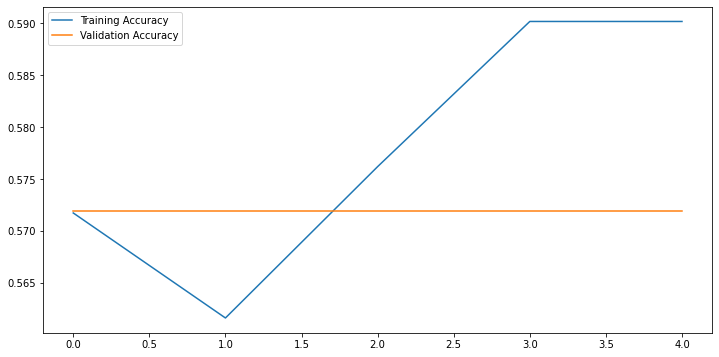

In [29]:
# Plot training results
plt.figure(figsize=(12,6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()


In [11]:
# Save the model
torch.save(classifier.state_dict(), 'model.pth')

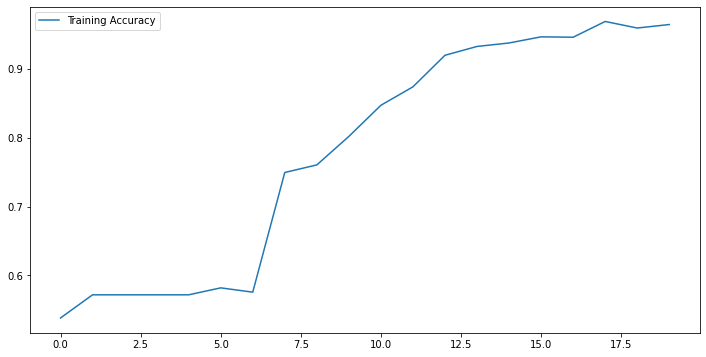

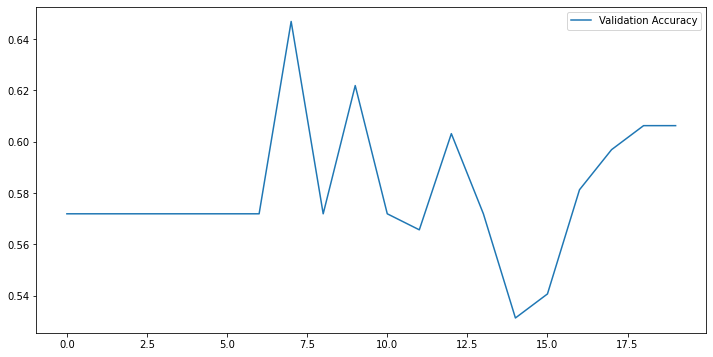

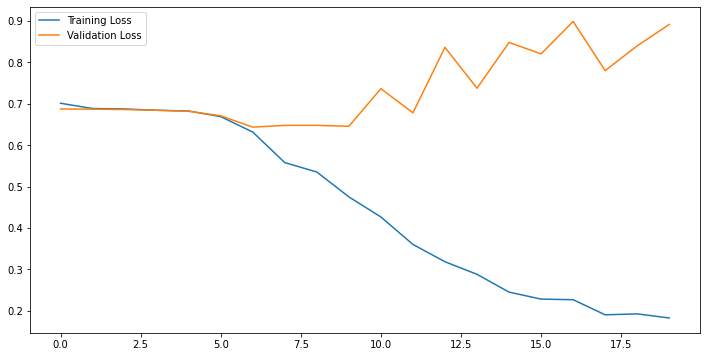

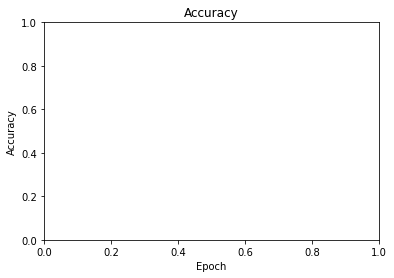

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.legend()
plt.figure(figsize=(12,6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
# Plot loss
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('accuracy.png')